In [1]:
!conda install -c conda-forge folium=0.5.0 --yes

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    scikit-learn-0.20.1        |   py36h22eb022_0         5.7 MB
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    liblapack-3.8.0            |      11_openblas          10 KB  conda-forge
    scipy-1.3.2                |   py36h921218d_0        18.0 MB  conda-forge
    libopenblas-0.3.6          |       h5a2b251_2         7.7 MB
    liblapacke-3.8.0           |      11_openblas          10 KB  conda-forge
    numpy-1.17.3               |   py36h95a1406_0         5.2 MB  conda-forge


In [4]:
! conda install -c anaconda beautifulsoup4 --y

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - beautifulsoup4


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1              |       h7b6447c_0         5.0 MB  anaconda
    beautifulsoup4-4.8.1       |           py36_0         153 KB  anaconda
    certifi-2019.11.28         |           py36_0         156 KB  anaconda
    soupsieve-1.9.5            |           py36_0          61 KB  anaconda
    ------------------------------------------------------------
                                           Total:         5.4 MB

The following NEW packages will be INSTALLED:

    soupsieve:      1.9.5-py36_0      an

In [17]:
import numpy as np                        # library to handle data in a vectorized manner
import pandas as pd                       # library for data analsysis
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import json                               # library to handle JSON files
import requests                           # library to handle requests
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans        # import k-means from clustering stage
import matplotlib.cm as cm                # Matplotlib and associated plotting modules
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import folium 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
print('Libraries imported.')

Libraries imported.


# Extract data, clean, transform

In [8]:
page = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
data=requests.get(page).text
soup = BeautifulSoup(data)
data_table = soup.find('table')
table_row = data_table.find_all('tr')
dataframe = []
for row in table_row:
    table_data = row.find_all('td')
    data = [i.text.rstrip() for i in table_data]
#     print(data)
    dataframe.append(data)

dataframe 
del dataframe[0]
# Add labels to the dataframe
labels = ['Postcode', 'Borough', 'Neighborhood']

# Create pandas dataframe and load it with data
data_table_df = pd.DataFrame.from_records(dataframe, columns=labels)

# Remove the not assigned values in Borough
data_table_df = data_table_df[data_table_df.Borough != 'Not assigned']

# Replace the not assigned values in Neighborhood.
data_table_df.Neighborhood = data_table_df.Neighborhood.replace('Not assigned', data_table_df.Borough)  

# Group Neighborhoods with same Postalcodes
data_table_df = data_table_df.groupby(("Postcode", "Borough")).agg(','.join)
data_table_df.reset_index(inplace=True)
df_geo_coordinate = pd.read_csv('https://cocl.us/Geospatial_data')
data_df = data_table_df.join(df_geo_coordinate.set_index('Postal Code'), on='Postcode')
data_df.rename(columns={'Postcode':'PostalCode'},inplace=True)
data_df.head(12)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:28: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park,Ionview,Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea,Golden Mile,Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest,Cliffside,Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff,Cliffside West",43.692657,-79.264848


## Create a map of Toronto with neighborhoods

In [13]:
map_toronto = folium.Map(location=[43.6532,-79.3832], zoom_start=11)

for location in data_df.itertuples(): #iterate each row of the dataframe
    label = 'Postal Code: {};  Borough: {};  Neighborhoods: {}'.format(location[1], location[2], location[3])
    label = folium.Popup(label, parse_html=True)    
    folium.CircleMarker(
        [location[-2], location[-1]],
        radius=1,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto) 
    folium.Circle(
        radius=500,
        popup=label,
        location=[location[-2], location[-1]],
        color='#3186cc',
        fill=True,
        fill_color='#3186cc'
    ).add_to(map_toronto) 
    
map_toronto

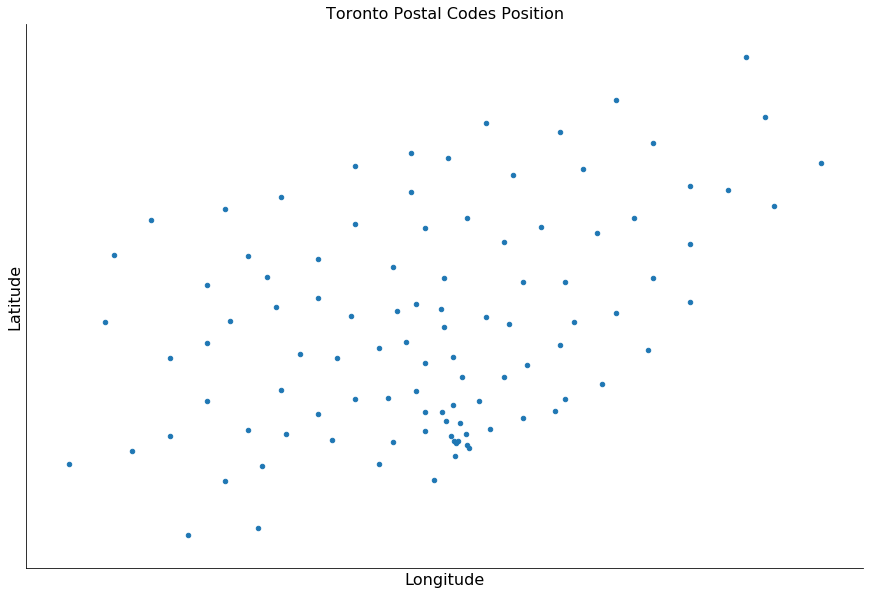

In [15]:
X = data_df[['Longitude', 'Latitude']]

scatter_plot = X.plot.scatter(x='Longitude', 
               y='Latitude',  
               fontsize = 16,
               figsize=(15, 10))

scatter_plot.set_yticklabels([])
scatter_plot.set_xticklabels([])
scatter_plot.set_xticks([])
scatter_plot.set_yticks([])
scatter_plot.spines['top'].set_color(None)
scatter_plot.spines['right'].set_color(None)
plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
scatter_plot.set_title('Toronto Postal Codes Position', fontsize=16)

scatter_plot.set_yticklabels(labels = 'Latitude', fontdict={'fontsize': 20})
plt.show()

In [20]:
! conda install -c conda-forge geopy --y

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         240 KB

The following NEW packages will be INSTALLED:

    geographiclib: 1.50-py_0         conda-forge
    geopy:         1.20.0-py_0       conda-forge

The following pa

### Find the closest points for each postcode.

In [21]:
from geopy.distance import great_circle

#function to get the closest postcode pair and the distance using latitude and longitude
def closest_postcode(postcode, postcodes):
    postcode = np.asarray(postcode).reshape(1,-1)
    postcodes = np.asarray(postcodes)
    distances = [great_circle(postcode, point).meters for point in postcodes]
    closest_postcode_index = np.argmin(distances)
    return [round(distances[closest_postcode_index]), closest_postcode_index]

### Looking for closest postcode for the dataframe 

In [22]:
coordinates = data_df[['Latitude', 'Longitude']]

distance, closest_point_index = closest_postcode(coordinates[:1], coordinates[~coordinates.index.isin([0])])
close_points = X[:1].append(X[closest_point_index+1:closest_point_index+2])
close_points

,Longitude,Latitude
0,-79.194353,43.806686
16,-79.205636,43.836125


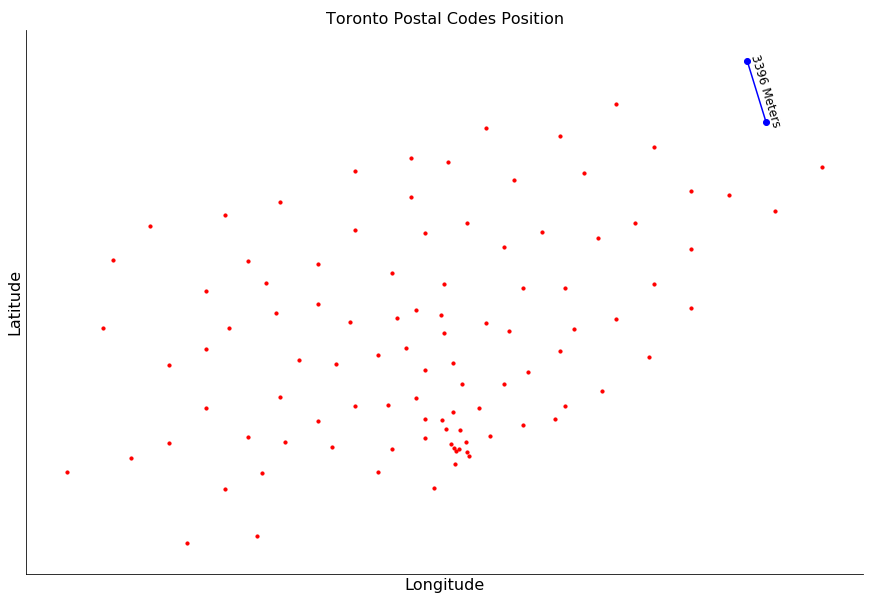

In [23]:
fig = plt.figure(figsize=(15,10))
scatter_plot = fig.add_subplot(111)
scatter_plot.scatter(X['Longitude'],X['Latitude'], s=10, c='r', marker="o")
scatter_plot.plot(close_points['Longitude'], close_points['Latitude'], c='b', marker="o")

# plt.legend(loc='upper left');
scatter_plot.annotate('{} Meters'.format(distance),
            xy=(.859, .912), xycoords='figure fraction',
            ha='left', va='top', rotation=-73,
            fontsize=12)

scatter_plot.set_yticklabels([])
scatter_plot.set_xticklabels([])
scatter_plot.set_xticks([])
scatter_plot.set_yticks([])
scatter_plot.spines['top'].set_color(None)
scatter_plot.spines['right'].set_color(None)

plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.title('Toronto Postal Codes Position', fontsize=16)

scatter_plot.set_yticklabels(labels = 'Latitude', fontdict={'fontsize': 20})
plt.show()

### A distant column is added to the DataFrame and is used as the radius cover for each postcode

In [25]:
from math import isnan

for lat, lng, idx in zip(data_df['Latitude'], data_df['Longitude'], data_df.index):
    distance, closest_point_index = closest_postcode([lat,lng], coordinates[~coordinates.index.isin([idx])])
    data_df.at[idx,'Distance'] = np.int64(distance//2) #use the half of the disstance to avoid overlapping
    
data_df.head(15)

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Distance
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353,1698.0
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,1625.0
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711,1205.0
3,M1G,Scarborough,Woburn,43.770992,-79.216917,913.0
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,913.0
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,1301.0
6,M1K,Scarborough,"East Birchmount Park,Ionview,Kennedy Park",43.727929,-79.262029,1112.0
7,M1L,Scarborough,"Clairlea,Golden Mile,Oakridge",43.711112,-79.284577,1052.0
8,M1M,Scarborough,"Cliffcrest,Cliffside,Scarborough Village West",43.716316,-79.239476,1112.0
9,M1N,Scarborough,"Birch Cliff,Cliffside West",43.692657,-79.264848,1297.0


In [27]:
map_toronto = folium.Map(location=[43.6532,-79.3832], zoom_start=11)

for location in data_df.itertuples(): #iterate each row of the dataframe
    label = 'Postal Code: {};  Borough: {};  Neighborhoods: {}'.format(location[1], location[2], location[3])
    label = folium.Popup(label, parse_html=True)    
    folium.CircleMarker(
        [location[-3], location[-2]],
        radius=1,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto) 
    folium.Circle(
        radius=location[-1],
        popup=label,
        location=[location[-3], location[-2]],
        color='#3186cc',
        fill=True,
        fill_color='#3186cc'
    ).add_to(map_toronto) 
    
map_toronto

### Define Foursquare Credentials and Version

In [28]:
CLIENT_ID = 'XM5S5YSHAFKHXPWUZEVU5UFYYM2UVPYEOXBOZ1HVLDVUSO1D' # your Foursquare ID
CLIENT_SECRET = 'BM3DYWQNSIPRKXNJGKPPZK2WSW2BTAFGSJSPSIL4J2XQ4HLZ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

### Create the GET request URL. Name my URL url.

In [29]:
def format_url(lat, lng, radius=500, limit=100):
    return 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, 
        lat, lng, VERSION, radius, limit)
first_postcode = data_df.iloc[2, :]
url = format_url(first_postcode['Latitude'], first_postcode['Longitude'], first_postcode['Distance'])

url

'https://api.foursquare.com/v2/venues/explore?client_id=XM5S5YSHAFKHXPWUZEVU5UFYYM2UVPYEOXBOZ1HVLDVUSO1D&client_secret=BM3DYWQNSIPRKXNJGKPPZK2WSW2BTAFGSJSPSIL4J2XQ4HLZ&ll=43.7635726,-79.1887115&v=20180605&radius=1205.0&limit=100'

### Get batch of venues as a dataframe

In [31]:
def get_venues(url):
    results = requests.get(url).json()
    venues = results['response']['groups'][0]['items']
    return json_normalize(venues)

venues_df = get_venues(url)
venues_df.head()

,referralId,reasons.count,reasons.items,venue.id,venue.name,venue.location.address,venue.location.crossStreet,venue.location.lat,venue.location.lng,venue.location.labeledLatLngs,venue.location.distance,venue.location.postalCode,venue.location.cc,venue.location.city,venue.location.state,venue.location.country,venue.location.formattedAddress,venue.categories,venue.photos.count,venue.photos.groups
0,e-0-4bc366dab492d13a51b2a860-0,0,"[{'summary': 'This spot is popular', 'type': '...",4bc366dab492d13a51b2a860,Chick-N-Joy,4449 Kingston Road,at Lawrence and Morningside,43.768752,-79.187982,"[{'label': 'display', 'lat': 43.76875171771289...",579,M1E 2N7,CA,Scarborough,ON,Canada,[4449 Kingston Road (at Lawrence and Morningsi...,"[{'id': '4d4ae6fc7a7b7dea34424761', 'name': 'F...",0,[]
1,e-0-4ba164fdf964a52039b337e3-1,0,"[{'summary': 'This spot is popular', 'type': '...",4ba164fdf964a52039b337e3,Bulk Barn,4525 Kingston Rd,Morningside Crossing,43.771342,-79.184341,"[{'label': 'display', 'lat': 43.77134173380578...",933,NaN,CA,West Hill,ON,Canada,"[4525 Kingston Rd (Morningside Crossing), West...","[{'id': '4bf58dd8d48988d1f9941735', 'name': 'F...",0,[]
2,e-0-4b3a9504f964a520646a25e3-2,0,"[{'summary': 'This spot is popular', 'type': '...",4b3a9504f964a520646a25e3,LCBO,4525 Kingston Rd.,at Lawrence Ave. E,43.771462,-79.184384,"[{'label': 'display', 'lat': 43.77146181777272...",944,M1E 2P1,CA,Toronto,ON,Canada,"[4525 Kingston Rd. (at Lawrence Ave. E), Toron...","[{'id': '4bf58dd8d48988d186941735', 'name': 'L...",0,[]
3,e-0-4c9fdb04542b224bca4201a0-3,0,"[{'summary': 'This spot is popular', 'type': '...",4c9fdb04542b224bca4201a0,Little Caesars Pizza,4218 Lawrence Avenue East,NaN,43.769046,-79.184386,"[{'label': 'display', 'lat': 43.76904597684398...",701,M1E 4X9,CA,Scarborough,ON,Canada,"[4218 Lawrence Avenue East, Scarborough ON M1E...","[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",0,[]
4,e-0-4beca2f9d6e676b0538764d4-4,0,"[{'summary': 'This spot is popular', 'type': '...",4beca2f9d6e676b0538764d4,Booster Juice,"4525 Kingston Road, Unit #H8",at Collinsgrove Rd.,43.770668,-79.184150,"[{'label': 'display', 'lat': 43.77066813, 'lng...",870,M1E 2P1,CA,Scarborough,ON,Canada,"[4525 Kingston Road, Unit #H8 (at Collinsgrove...","[{'id': '52f2ab2ebcbc57f1066b8b41', 'name': 'S...",0,[]


### It is time to clean

In [32]:
def clean_df(df):
    relevant_columns = ['venue.categories', 'venue.location.lat', 'venue.location.lng', 'venue.name']
    clean_df = df.loc[:,relevant_columns]

    #rename columns
    clean_df.columns = ['Category', 'Lat', 'Lng', 'Name']
    return clean_df 

venues_df = clean_df(venues_df)
venues_df.head()

,Category,Lat,Lng,Name
0,"[{'id': '4d4ae6fc7a7b7dea34424761', 'name': 'F...",43.768752,-79.187982,Chick-N-Joy
1,"[{'id': '4bf58dd8d48988d1f9941735', 'name': 'F...",43.771342,-79.184341,Bulk Barn
2,"[{'id': '4bf58dd8d48988d186941735', 'name': 'L...",43.771462,-79.184384,LCBO
3,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",43.769046,-79.184386,Little Caesars Pizza
4,"[{'id': '52f2ab2ebcbc57f1066b8b41', 'name': 'S...",43.770668,-79.184150,Booster Juice


In [33]:
venues_df.loc[0, 'Category']

[{'id': '4d4ae6fc7a7b7dea34424761',
  'name': 'Fried Chicken Joint',
  'pluralName': 'Fried Chicken Joints',
  'shortName': 'Fried Chicken',
  'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/friedchicken_',
   'suffix': '.png'},
  'primary': True}]

In [34]:
def get_category_name(row):
    category_json = row['Category']
    try:
        return category_json[0]['name']
    except:        
        return None

venues_df['Category'] = venues_df.apply(get_category_name, axis=1)

venues_df

,Category,Lat,Lng,Name
0,Fried Chicken Joint,43.768752,-79.187982,Chick-N-Joy
1,Food & Drink Shop,43.771342,-79.184341,Bulk Barn
2,Liquor Store,43.771462,-79.184384,LCBO
3,Pizza Place,43.769046,-79.184386,Little Caesars Pizza
4,Smoothie Shop,43.770668,-79.184150,Booster Juice
5,Pizza Place,43.767697,-79.189914,Swiss Chalet Rotisserie & Grill
6,Breakfast Spot,43.772319,-79.184900,Sunset Grill
7,Pharmacy,43.770282,-79.185012,Shoppers Drug Mart
8,Beer Store,43.769793,-79.187505,The Beer Store
9,Coffee Shop,43.770370,-79.186490,Starbucks


### Get venues

In [40]:
def get_all_venues(postcodes, lat, lng, radius):
    venues_list=[]
    for postcode, lat, lng, radius in zip(postcodes, lat, lng, radius):
        url= format_url(lat, lng, radius)
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        venues_list.append([(
            postcode, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'], 
            v['venue']['categories'][0]['name'])
            for v in results])
    all_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    all_venues.columns = ['PostalCode', 
                  'PostalCode Latitude', 
                  'PostalCode Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Category'
                  ]
    
    return all_venues
all_venues = get_all_venues(data_df['PostalCode'], data_df['Latitude'], data_df['Longitude'], data_df['Distance'])

print('The total number of venues returned is ', all_venues.shape[0])

all_venues.head(10)

The total number of venues returned is  3355


,PostalCode,PostalCode Latitude,PostalCode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M1B,43.806686,-79.194353,African Rainforest Pavilion,43.817725,-79.183433,Zoo Exhibit
1,M1B,43.806686,-79.194353,Images Salon & Spa,43.802283,-79.198565,Spa
2,M1B,43.806686,-79.194353,Canadiana exhibit,43.817962,-79.193374,Zoo Exhibit
3,M1B,43.806686,-79.194353,Orangutan Exhibit,43.818413,-79.182548,Zoo Exhibit
4,M1B,43.806686,-79.194353,penguin exhibit,43.819435,-79.185959,Zoo Exhibit
5,M1B,43.806686,-79.194353,Gorilla Exhibit,43.819080,-79.184235,Zoo Exhibit
6,M1B,43.806686,-79.194353,Lion Exhibit,43.819228,-79.186977,Zoo Exhibit
7,M1B,43.806686,-79.194353,Giraffe Exhibit,43.819851,-79.186692,Zoo Exhibit
8,M1B,43.806686,-79.194353,Caribbean Wave,43.798558,-79.195777,Caribbean Restaurant
9,M1B,43.806686,-79.194353,LCBO,43.796671,-79.204586,Liquor Store


###  Analyze the venuee data

In [45]:
venues_in_postcode = all_venues.groupby('PostalCode').count()
venues_in_postcode = pd.DataFrame(list(zip(venues_in_postcode.index, venues_in_postcode['Venue'])), 
                                  columns=['PostalCode', '# of Venues']).set_index('PostalCode').join(data_df[['PostalCode','Distance']].set_index('PostalCode'), on='PostalCode').reset_index()
venues_in_postcode['Distance'] = np.int64(venues_in_postcode['Distance'])
venues_in_postcode.loc[len(venues_in_postcode.index)] = ['M5E', 0, 111] #add M5E (postcode without venues) with zero as # of venues

venues_in_postcode.head(10)

,PostalCode,# of Venues,Distance
0,M1B,36,1698
1,M1C,9,1625
2,M1E,30,1205
3,M1G,5,913
4,M1H,22,913
5,M1J,26,1301
6,M1K,27,1112
7,M1L,34,1052
8,M1M,19,1112
9,M1N,14,1297


In [46]:
venues_in_postcode[['# of Venues']].describe()

,# of Venues
count,103.000000
mean,32.572816
std,25.772992
min,0.000000
25%,12.000000
50%,26.000000
75%,45.000000
max,100.000000


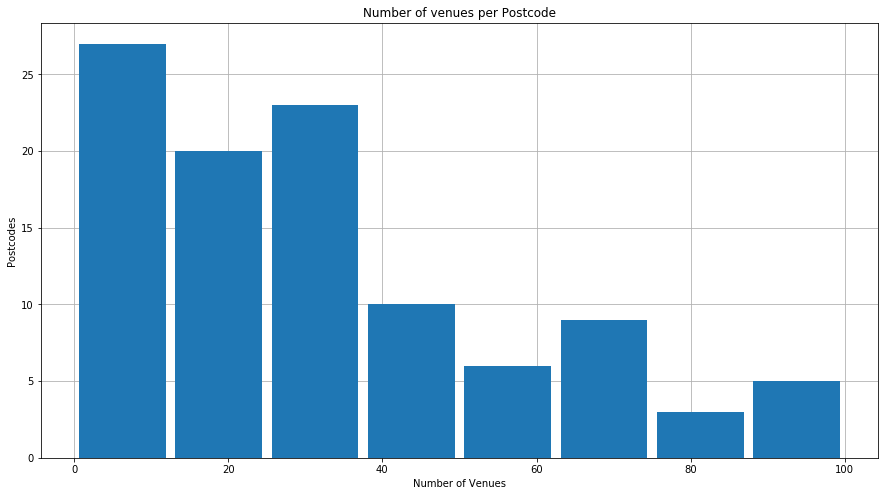

In [47]:
venues_in_postcode['# of Venues'].hist(bins=8, figsize=(15,8),zorder=2, rwidth=0.9)

plt.xlabel('Number of Venues')
plt.ylabel('Postcodes')
plt.title('Number of venues per Postcode')
plt.show()

In [50]:
density_venues_in_postcode = all_venues.groupby('PostalCode').count()

density_venues_in_postcode = pd.DataFrame(list(zip(density_venues_in_postcode.index, density_venues_in_postcode['Venue'])), 
                                  columns=['PostalCode', 'Density']).set_index('PostalCode').join(data_df[['PostalCode','Distance']].set_index('PostalCode'), on='PostalCode').reset_index()
density_venues_in_postcode['Density'] = np.int64(density_venues_in_postcode['Density']/(density_venues_in_postcode['Distance']/1000)) #distance in km
density_venues_in_postcode.loc[len(venues_in_postcode.index)] = ['M5E', 0, 111] #add M5E (postcode without venues) with zero as density

density_venues_in_postcode.head(10)

,PostalCode,Density,Distance
0,M1B,21,1698.0
1,M1C,5,1625.0
2,M1E,24,1205.0
3,M1G,5,913.0
4,M1H,24,913.0
5,M1J,19,1301.0
6,M1K,24,1112.0
7,M1L,32,1052.0
8,M1M,17,1112.0
9,M1N,10,1297.0


In [51]:
density_venues_in_postcode[['Density']].describe()

,Density
count,103.000000
mean,46.184466
std,48.982539
min,0.000000
25%,15.000000
50%,30.000000
75%,56.500000
max,277.000000


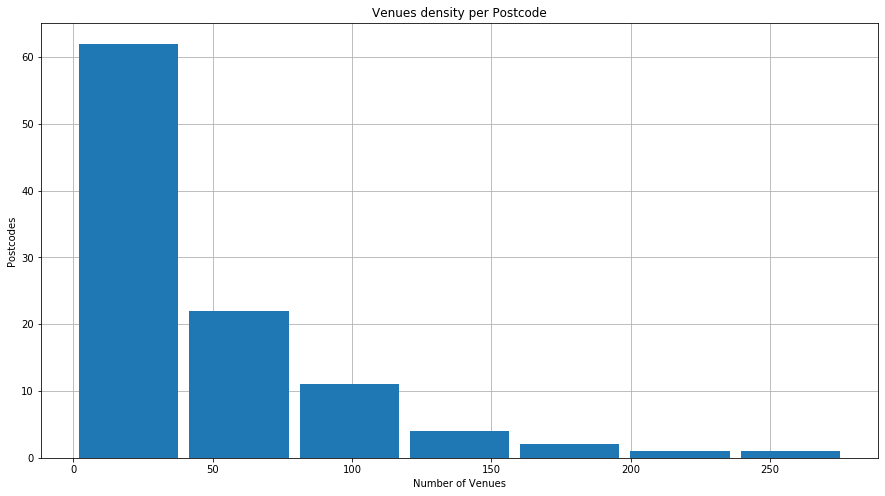

In [52]:
density_venues_in_postcode['Density'].hist(bins=7, figsize=(15,8),zorder=2, rwidth=0.9)

plt.xlabel('Number of Venues')
plt.ylabel('Postcodes')
plt.title('Venues density per Postcode')
plt.show()

## Examine Clusters

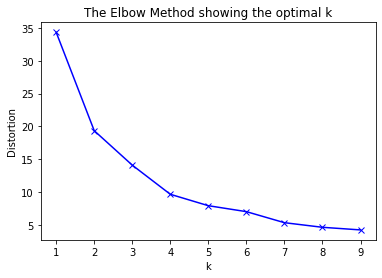

In [53]:
from sklearn import metrics
from scipy.spatial.distance import cdist

distortions = []
K = range(1,10)
for k in K:
    k_means = KMeans(init = "k-means++", n_clusters = k, n_init = 12)
    k_means.fit(density_venues_in_postcode['Density'].values.reshape(-1, 1))
    distortions.append(sum(np.min(cdist(density_venues_in_postcode['Density'].values.reshape(-1, 1),
                                        k_means.cluster_centers_, 'euclidean'), axis=1)) / density_venues_in_postcode['Density'].shape[0])

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [54]:
num_clusters = 5

k_means = KMeans(init = "k-means++", n_clusters = num_clusters, n_init = 12)
k_means.fit(density_venues_in_postcode['Density'].values.reshape(-1, 1))
labels = k_means.labels_

print(labels)

[3 3 3 3 3 3 3 1 3 3 1 1 1 1 1 1 3 3 1 3 3 1 4 1 1 1 3 1 1 3 3 3 3 3 3 3 3
 4 4 1 1 2 1 2 3 3 1 4 3 4 3 4 0 4 0 4 4 2 0 1 2 1 3 3 1 4 0 1 4 2 1 3 3 3
 1 1 2 4 3 3 1 4 4 4 3 1 1 1 1 1 3 1 3 3 3 3 3 3 3 3 3 3 3]


In [55]:
density_venues_in_postcode['Cluster'] = k_means.labels_
density_venues_in_postcode.head(10)

,PostalCode,Density,Distance,Cluster
0,M1B,21,1698.0,3
1,M1C,5,1625.0,3
2,M1E,24,1205.0,3
3,M1G,5,913.0,3
4,M1H,24,913.0,3
5,M1J,19,1301.0,3
6,M1K,24,1112.0,3
7,M1L,32,1052.0,1
8,M1M,17,1112.0,3
9,M1N,10,1297.0,3


### Check the centroid values of venues density and postcodes per cluster

In [57]:
centroids = np.int64(round(density_venues_in_postcode.groupby('Cluster').mean()['Density']))
frecuency = density_venues_in_postcode.groupby('Cluster').count()['PostalCode']

cluster_info = pd.DataFrame([np.arange(0,5), centroids, frecuency], index=['Cluster', 'Centroid','PostalCodes']).T
cluster_info.sort_values('Centroid', inplace=True)
cluster_info.reset_index(drop=True, inplace=True)

cluster_info

,Cluster,Centroid,PostalCodes
0,3,14,46
1,1,39,32
2,4,84,15
3,2,124,6
4,0,223,4



Based on the centroids of each cluster, the cluster names can be defined as:

1. **Low Venues Density** Centroid equal to 14
2. **Medium-Low Venues Density** with a centroid equal to 39
3. **Medium-High Venues Density** with a centroid equal to 84
4. **High Venues Density** with a centroid equal to 124
5. **Very High Venues Density** with a centroid equal to 223

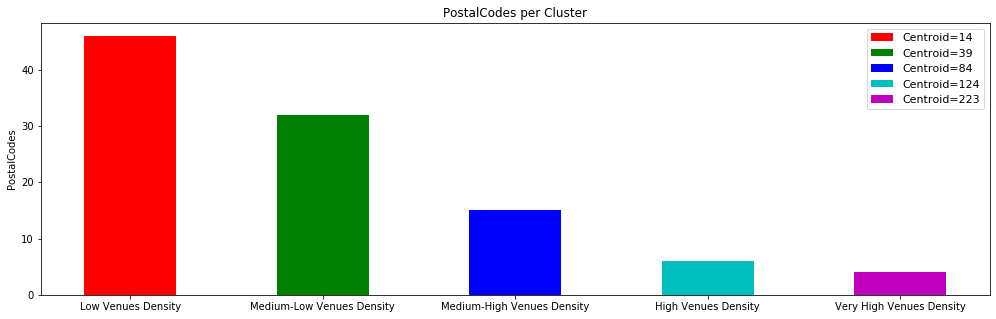

In [60]:
fig, ax = plt.subplots(figsize=(17,5))
clusters= ['Low Venues Density','Medium-Low Venues Density','Medium-High Venues Density','High Venues Density','Very High Venues Density']
colors = ['r','g','b','c','m']
legend = []

for id, cluster in enumerate(clusters):
    legend.append('Centroid={}'.format(cluster_info['Centroid'][id]))
    bar = ax.bar(cluster, cluster_info['PostalCodes'][id], 0.48, color=colors[id])

ax.set_ylabel('PostalCodes')
ax.set_title('PostalCodes per Cluster')
# ax.set_facecolor((1,1,1))
# ax.grid(True, axis='y',color='k', linestyle='-', linewidth=1)

plt.legend(legend, fontsize=11)

plt.show()

In [62]:
data_df = pd.concat([data_df[:56],data_df[57:],data_df[56:57]]) #move M5E to the last row
data_df['Cluster'] = k_means.labels_

colors = ['red','green','blue','cyan','magenta']
clusters_values = cluster_info['Cluster']

map = folium.Map(location=[43.6532,-79.3832], zoom_start=11)

for location in data_df.itertuples(): #iterate each row of the dataframe
    cluster_index = clusters_values.index[clusters_values==location[-1]][0]
    label = 'Postal Code: {};  Borough: {};  Neighborhoods: {}; {}'.format(location[1], location[2], location[3], clusters[cluster_index])
    label = folium.Popup(label, parse_html=True)    
    folium.Circle(
        radius=location[-2],
        popup=label,
        location=[location[-4], location[-3]],
        color=None,
        fill=True,
        fill_opacity=0.4,
        fill_color=colors[cluster_index]
    ).add_to(map) 

map

#### Result

1. Real estate: as part of property cost model (venues density could be related to the cost of a property) or as a tool for property search.
2. Epidemiology research: venues density could be related with noise, pollution or crime.